# <font color="red"> CellProfiler: Quantification of cytoplasmic/nuc TDP43 -/+DOX across all batches</font>

JIRA task: NN-88: 

Why Linear Mixed-Effects Models (LMMs)?
Your experimental structure involves:

- Two groups: dNLS_Untreated vs dNLS_DOX

- 5 batches per group

- Measurements per site image (the dependent variable), 50–250 site images per batch (i.e., image-level measurements)


- Random variation across batches random intercept per batch (i.e., variation across batches)

This design includes both fixed effects (groups) and random effects (batches)
Estimate how dNLS_DOX affects each CellProfiler feature vs dNLS_Untreated, accounting for batch effects (inter-batch variation).

In [1]:
from pathlib import Path
import glob
import sys
import os


os.environ['NOVA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA/'
os.environ['NOVA_DATA_HOME'] = f"{os.environ['NOVA_HOME']}/input"
print('NOVA_HOME is at', os.getenv('NOVA_HOME'))
sys.path.insert(1, os.getenv('NOVA_HOME'))


import numpy as np
import pandas as pd
import seaborn as sns
from markdown import markdown
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from cell_profiler.code.cp_effect_size_utils import CP_OUTPUTS_FOLDER, validate_cp_files, extract_path_parts, merge_on_group, collect_cp_results_by_cell_line, load_cp_results, get_features_per_image, get_aggregated_features_per_image, get_aggregated_features_per_image, run_analysis_generate_report, print_mixedlm_conclusions, plot_cp_feature_grouped_by_gene
from manuscript.plot_config import PlotConfig

%load_ext autoreload    
%autoreload 2

NOVA_HOME is at /home/projects/hornsteinlab/Collaboration/NOVA/


# New dNLS dataset

In [3]:
ANALYSIS_TYPE = 'TDP_localization/dNLS_cyto_TDP43'

BATCHES = ['batch1', 'batch2', 'batch4', 'batch5', 'batch6']

# Save figures here
save_path = '/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/dNLS/cell_profiler/TDP_localization/dNLS_cyto_TDP43'

# Font
FONT_PATH = '/home/projects/hornsteinlab/sagyk/anaconda3/envs/nova/fonts/arial.ttf'
from matplotlib import font_manager as fm
import matplotlib
fm.fontManager.addfont(FONT_PATH)
matplotlib.rcParams['font.family'] = 'Arial'

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 6
})

In [4]:
group_by_columns = ['ImageNumber', 'batch', 'rep', 'cell_line', 'condition']
cp_measures_cols = ["Math_TDP43_cyto_over_nuc"]

In [5]:
# Test CP outputs (number of images)
if True:
    pattern = os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, '*', '*', '*', '*', '*', '*')
    # store marker folders by cell line
    for marker_path in glob.glob(pattern):
        if os.path.isdir(marker_path):
            try:
                image_df = pd.read_csv(marker_path +'/Image.csv')
                print(marker_path, image_df.shape)
                #print(image_df[['Count_Pbodies', 'Count_nucleus']].head(10))

                # parts_df = image_df['URL_DAPI'].apply(extract_path_parts)
                # print(marker_path, parts_df['rep'].unique(), parts_df['cell_line'].unique())

                marker = os.path.basename(marker_path)    
                cell_line = Path(marker_path).resolve().parents[3].name
            except FileNotFoundError as e:
                print("!!!!")
                print(e)
        else:
            print(f"Not a marker folder directory:{marker_path}")


/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/dNLS_cyto_TDP43/batch5/WT/panelI/Untreated/rep1/TDP43 (250, 306)
/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/dNLS_cyto_TDP43/batch5/WT/panelI/Untreated/rep2/TDP43 (249, 306)
/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/dNLS_cyto_TDP43/batch5/dNLS/panelI/Untreated/rep3/TDP43 (250, 306)
/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/dNLS_cyto_TDP43/batch5/dNLS/panelI/Untreated/rep1/TDP43 (250, 306)
/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/dNLS_cyto_TDP43/batch5/dNLS/panelI/Untreated/rep2/TDP43 (245, 306)
/home/projects/hornsteinlab/Collaboration/NOVA/cell_pr

## Collect CP files by "cell_line" (paths_by_cell_line[cell_line]) and Load CP data

In [6]:

# Get the calculated features from all CP output files
paths_by_cell_line = collect_cp_results_by_cell_line(ANALYSIS_TYPE, include_condition=False, validate=False)


In [7]:
# Load CP data
cp_data = load_cp_results(paths_by_cell_line, REQUIRED_FILES=['Cytoplasm.csv'])


number of subjects from cell line WT: 10
number of subjects from cell line dNLS: 30


In [8]:
# Get the calculated features from CP output files

dfs = []
for cell_line in cp_data:

    # 'Cytoplasm.csv'
    pb_cyto_site_means = get_aggregated_features_per_image(
        cp_file_name='Cytoplasm.csv', 
        measurement_cols=cp_measures_cols, 
        cp_data=cp_data, 
        cell_line=cell_line, 
        group_by_columns=group_by_columns, 
        agg_function=np.mean
     )
    
    dfs.append(pb_cyto_site_means)

cp_measurements = pd.concat(dfs, ignore_index=True)
print("Shape after merging is:", cp_measurements.shape)        


Shape after merging is: (7203, 6)


# Remove batch 3, remove WT, add new variable "group"

In [9]:
# Remove batch 3
cp_measurements = cp_measurements[cp_measurements['batch'].isin(BATCHES)]

# Add group
cp_measurements['group'] = cp_measurements['cell_line']+"_"+cp_measurements['condition']

# Fiilter by lines
lines_to_include = ["dNLS_Untreated", "dNLS_DOX"]
cp_measurements = cp_measurements[cp_measurements['group'].isin(lines_to_include)]
print(cp_measurements.shape)

# Important to put the reference group first in order for mixedlm() - has to be Categorical!
cp_measurements["group"] = pd.Categorical(
    cp_measurements["group"],
    categories=lines_to_include,
    ordered=True
)


(5321, 7)


In [10]:
cp_measurements[['batch', 'group']].value_counts()


batch   group         
batch5  dNLS_Untreated    745
        dNLS_DOX          736
batch4  dNLS_DOX          728
        dNLS_Untreated    625
batch2  dNLS_DOX          586
batch6  dNLS_DOX          477
batch1  dNLS_DOX          476
        dNLS_Untreated    353
batch2  dNLS_Untreated    311
batch6  dNLS_Untreated    284
Name: count, dtype: int64

In [11]:
cp_measurements[['batch']].value_counts()

batch 
batch5    1481
batch4    1353
batch2     897
batch1     829
batch6     761
Name: count, dtype: int64

In [12]:
cp_measurements[['group']].value_counts()

group         
dNLS_DOX          3003
dNLS_Untreated    2318
Name: count, dtype: int64

# Effect size modeling

The terms in the formula:
- measurement: The CellProfiler feature (e.g., mean number of p-bodies).
- gene_group: A fixed effect to test differences between WT, C9, +sALS, -sALS.
- rep: Random intercept for each patient, accounting for intra-patient correlation across site images.

What This Model Gives You:
- Estimates of group differences: WT vs other groups, with significance testing.

- Within-patient variability: Captures how consistent measurements are across images for a given patient.

- Between-patient variability: Tests whether observed effects are reproducible across patients.

- P-values or confidence intervals: For significance of gene group effects.



In [13]:

cp_measurements[['group', 'mean_Math_TDP43_cyto_over_nuc']].groupby('group', observed=False).describe()

mean_Math_TDP43_cyto_over_nuc                                \
                                       count      mean       std       min   
group                                                                        
dNLS_Untreated                        2318.0  0.178180  0.115538  0.010979   
dNLS_DOX                              3003.0  0.709998  0.350533  0.014058   

                                                        
                     25%       50%       75%       max  
group                                                   
dNLS_Untreated  0.083957  0.166788  0.246894  1.797804  
dNLS_DOX        0.453639  0.716769  0.943910  3.331670

In [14]:
# get the CellProfiler features you want to calculate effect for 
cp_features_columns = [col for col in cp_measurements.columns if col not in group_by_columns + ['group', 'batch']]

results_df = run_analysis_generate_report(
                                df=cp_measurements,
                                feature_columns=cp_features_columns,
                                group_col="group",
                                batch_col="batch",
                                output_dir=os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, 'mixed_effect_report')
)

results_df





Analysing CP feature: mean_Math_TDP43_cyto_over_nuc
⚠️ Warning during model fit for feature mean_Math_TDP43_cyto_over_nuc: UserWarning: Random effects covariance is singular
⚠️ Warning during model fit for feature mean_Math_TDP43_cyto_over_nuc: UserWarning: The random effects covariance matrix is singular.
⚠️ Warning during model fit for feature mean_Math_TDP43_cyto_over_nuc: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
⚠️ Warning during model fit for feature mean_Math_TDP43_cyto_over_nuc: UserWarning: The random effects covariance matrix is singular.
⚠️ Warning during model fit for feature mean_Math_TDP43_cyto_over_nuc: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
❌ Random effect variance is near zero. — Unable to fit random intercept (e.g., low variance or convergence issue)
⚠️ Fallback to fixed-effects model for feature: mean_Math_TDP43_cyto_over_nuc
                            OLS Regression Resu

/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/code/cp_effect_size_utils.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _, results_df_wo_intercept["fdr_pval_global"], _, _ = multipletests(results_df_wo_intercept["pval"], method="fdr_bh")


,feature,comparison,effect_size,pval,ci_lower,ci_upper,group_var,residual_var,significance,fit_status,used_fixed_model,aic,bic,loglik,r_squared,fdr_pval_global
0,mean_Math_TDP43_cyto_over_nuc,Intercept,0.064233,9.244160e-11,0.044836,0.083629,NaN,0.066971,****,fallback_ols_fixed_batch,True,721.0193,760.495799,-354.50965,0.537604,NaN
1,mean_Math_TDP43_cyto_over_nuc,dNLS_DOX,0.550820,0.000000e+00,0.536697,0.564943,NaN,0.066971,****,fallback_ols_fixed_batch,True,721.0193,760.495799,-354.50965,0.537604,0.0


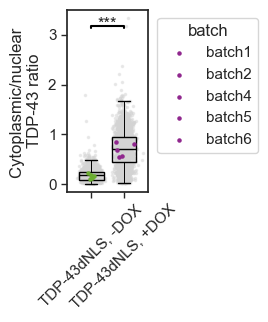

In [ ]:

def plot_cp_feature_grouped_by_gene(cp_measurements, cp_feature_col, group_col="gene_group", patient_col="patient_id", color_mapping=None, model_results_df=None):
    
    df = cp_measurements.copy()

    # Define fixed color and label mapping for both group_col and patient_col
    _palette = {}
    groups = df[group_col].astype(str).unique().tolist() + df[patient_col].astype(str).unique().tolist()
    for g in groups:
        if g in color_mapping: _palette[color_mapping[g]['alias']] = color_mapping[g]['color']
    if patient_col=='batch':
        for b in df[patient_col].astype(str).unique().tolist():
            _palette[b]='gray'

    
    # Rename groups to aliases
    label_mapping = {k: v["alias"] for k, v in color_mapping.items() if k in groups}
    df[group_col] = df[group_col].cat.rename_categories(label_mapping)
    df[patient_col] = df[patient_col].astype("category").cat.rename_categories(label_mapping)
    
    # Determine group order and x-axis positions for each group (reversed for visual preference)
    groups_order = sorted(df[group_col].unique(), reverse=True)
    x_spacing = 0.4
    x_pos_map = {label: i * x_spacing for i, label in enumerate(groups_order)}

    
    # Setup plot
    sns.set(style="white", font_scale=1.0)
    fig, ax = plt.subplots(figsize=(3, 4))
    line_width = 1

    
    # ============================
    # Plot each group manually by numeric x
    # ============================
    for i, group in enumerate(groups_order):
        
        group_data = df[df[group_col] == group]
        xpos = x_pos_map[group]
        
        # Boxplot for group
        sns.boxplot(
            data=group_data,
            y=cp_feature_col,
            ax=ax,
            width=0.3,
            linewidth=line_width,
            showfliers=False,
            showmeans=True,
            meanline=True,
            meanprops={"linestyle": "-", "color": "black", "linewidth": line_width },
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=line_width),
            whiskerprops=dict(linewidth=line_width-0.3, color='black'),
            capprops=dict(linewidth=line_width, color='black'),
            medianprops=dict(visible=False),
            positions=[x_pos_map[group]]
        )

        # ============================
        # Full distribution: raw cell-level/image-level points (light gray)
        # ============================ 
        ax.scatter(
            x=np.random.normal(loc=x_pos_map[group], scale=0.05, size=len(group_data)),  # jitter
            y=group_data[cp_feature_col],
            color='lightgray',
            s=2.5,
            alpha=0.4,
            zorder=1
        )

    # ============================
    # Overlay per-batch means (means as colored points)
    # ============================
    batch_means = df.groupby([group_col, patient_col], observed=True)[cp_feature_col].mean().reset_index()

    for _, row in batch_means.iterrows():
        group = row[group_col]
        batch = row[patient_col]
        xpos = x_pos_map[group]
        y = row[cp_feature_col]
        jittered_x = np.random.normal(loc=xpos, scale=0.05)

        ax.scatter(
            x=jittered_x,
            y=y,
            color=_palette.get(group, 'black'),
            edgecolor=None,
            s=5,
            zorder=3,
            label=batch
        )

    # Deduplicate legend
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(
        unique.values(),
        unique.keys(),
        title=patient_col,
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )

    # Set axis formatting
    ax.set_xlim(-x_spacing+0.1, max(x_pos_map.values()) + x_spacing - 0.1)
    
    ax.set_xticks(list(x_pos_map.values()))
    ax.set_xticklabels(groups_order, rotation=45)
    ax.set_ylabel('Cytoplasmic/nuclear \nTDP-43 ratio')
    ax.margins(x=0)
    
    # Ensure tick marks are shown on both axes
    ax.tick_params(axis='both', which='both', direction='out',
                   length=4, width=1, bottom=True, top=False, left=True, right=False)
    

    # ============================
    # P-value annotation LMM
    # ============================
    stat = model_results_df[model_results_df['comparison'] == 'dNLS_DOX']
    p = float(stat['pval'].iloc[0])

    #ci_low = float(stat['ci_lower'].values[0])
    #ci_high = float(stat['ci_upper'].values[0])
    #txt = f"(p = {p:.3f}, 95% CI: [{ci_low:.2f}, {ci_high:.2f}])"

    # Format p display
    if p < 0.0001:
        p_text = "****"
    elif p < 0.001:
        p_text = "***"
    elif p < 0.01:
        p_text = "**"
    elif p < 0.05:
        p_text = "*"
    else:
        p_text = f"n.s. (p = {p:.2f})"
        
    # Plot annotation - use actual plot limits to place annotation
    ymin, ymax = ax.get_ylim()
    y_range = ymax - ymin
    
    line_y = ymax - 0.1 * y_range
    text_y = line_y - 0.02 * y_range

    # Significance - Bridge line between two groups
    x_keys = list(x_pos_map.values())
    if len(x_keys) >= 2:
        x1, x2 = x_keys[0], x_keys[1]
        ymin, ymax = ax.get_ylim()
        y_range = ymax - ymin
        line_y = ymax - 0.1 * y_range
        text_y = line_y - 0.02 * y_range


        ax.plot([x1, x1, x2, x2],
                [line_y, line_y + 0.01*y_range, 
                 line_y + 0.01*y_range, line_y],
                lw=1.5, c='black')

        # Annotation text
        ax.text((x1 + x2) / 2, text_y, p_text, ha='center', va='bottom')
    
    
    # Remove extra space around plot
    plt.tight_layout()
    # Add top space if needed
    plt.subplots_adjust(top=0.8)

    # Save the plot
    plt.savefig(f"{save_path}/cell_profiler_dNLS_cyto_TDP43.pdf", dpi=300)
    plt.savefig(f"{save_path}/cell_profiler_dNLS_cyto_TDP43.png", dpi=300)

    plt.show()
    
plot_cp_feature_grouped_by_gene(cp_measurements, 
                                  cp_feature_col='mean_Math_TDP43_cyto_over_nuc',
                                  group_col='group', 
                                  patient_col="batch",
                                  color_mapping=PlotConfig().COLOR_MAPPINGS_DOX, 
                                  model_results_df=results_df)   

In [15]:
print("Done!")

Done!
